### 01g_advanced_algorithms_and_flow — Exploring Network Capabilities

### What this step does
This final notebook in the series applies more advanced graph algorithms to our network. It demonstrates how to compute a **Minimum Spanning Tree (MST)** to find the most efficient network backbone. It also sets up a hypothetical **Maximum Flow** problem to determine the capacity of a supply chain route between a source (warehouse) and a sink (hospital).

### Why this is useful
- **Minimum Spanning Tree:** Useful for network design problems, such as finding the cheapest way to connect all locations with a cable or road network.
- **Maximum Flow:** A classic operations research problem for modeling and solving logistics, pipeline capacity, and bandwidth problems in a network.
- Illustrates the broader capabilities of NetworkX for solving complex optimisation and design problems.

### Inputs
- `outputs/01f_communities_paths/graph_with_communities.graphml`

### Outputs
- `outputs/01g_advanced_algorithms/01g_mst_visualisation.png`
- `outputs/01g_advanced_algorithms/01g_max_flow_analysis.json`
- `outputs/01g_advanced_algorithms/final_graph.graphml` (includes capacity attributes)

### Key operations
- Load the graph containing community attributes.
- Compute the Minimum Spanning Tree using `nx.minimum_spanning_tree`.
- Visualise the resulting MST.
- Add a hypothetical `capacity` attribute to edges for the flow problem.
- Identify a source and sink node for the maximum flow calculation.
- Calculate the maximum flow value using `nx.maximum_flow_value`.
- Export the final graph and analysis results.

In [1]:
# --- Step 0: Imports and Configuration ---
# 203 # Final setup for the last notebook in the series. This cell imports
# 203 # necessary libraries and defines the configuration for input/output files.
# 203 # The structure remains consistent with the previous notebooks.

from __future__ import annotations

import json
import random
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# 203 # Display preferences.
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

@dataclass(frozen=True)
class Config:
    """Configuration object for file paths and parameters."""
    input_dir: Path
    output_dir: Path
    input_graph_file: Path
    output_graph_file: Path
    mst_viz_file: Path
    flow_summary_file: Path


def setup_config() -> Config:
    """Initialises configuration and creates directories."""
    root_dir = Path(".")
    input_dir = root_dir / "outputs" / "01f_communities_paths"
    output_dir = root_dir / "outputs" / "01g_advanced_algorithms"
    
    output_dir.mkdir(parents=True, exist_ok=True)

    return Config(
        input_dir=input_dir,
        output_dir=output_dir,
        input_graph_file=input_dir / "graph_with_communities.graphml",
        output_graph_file=output_dir / "final_graph.graphml",
        mst_viz_file=output_dir / "01g_mst_visualisation.png",
        flow_summary_file=output_dir / "01g_max_flow_analysis.json",
    )

cfg = setup_config()

print("--- Configuration Initialised ---")
print(f"Input graph: {cfg.input_graph_file}")
print(f"Outputs will be saved to: {cfg.output_dir}")

--- Configuration Initialised ---
Input graph: outputs/01f_communities_paths/graph_with_communities.graphml
Outputs will be saved to: outputs/01g_advanced_algorithms


In [2]:
# --- Step 1: Load Graph ---
# 203 # Load the final graph from the previous notebook, which contains all
# 203 # original attributes plus centrality and community information.

def load_graph(file_path: Path) -> nx.Graph:
    """Loads a graph from a GraphML file, ensuring attributes are correct types."""
    if not file_path.exists():
        raise FileNotFoundError(
            f"Graph file not found at {file_path}.\n"
            f"Please run notebook '01f_community_detection_and_pathfinding.ipynb' first."
        )
    G = nx.read_graphml(file_path)
    # 203 # Type correction for attributes that might be read as strings.
    for node, data in G.nodes(data=True):
        if 'pos' in data and isinstance(data['pos'], str):
            try: data['pos'] = eval(data['pos'])
            except Exception: data['pos'] = (0, 0)
        if 'community_id' in data: data['community_id'] = int(data['community_id'])
    
    for u, v, data in G.edges(data=True):
        if 'weight' in data: data['weight'] = float(data['weight'])

    print(f"Graph loaded from {file_path}.")
    return G

# 203 # Load the graph.
G = load_graph(cfg.input_graph_file)

Graph loaded from outputs/01f_communities_paths/graph_with_communities.graphml.


Minimum Spanning Tree calculated with 22 edges.


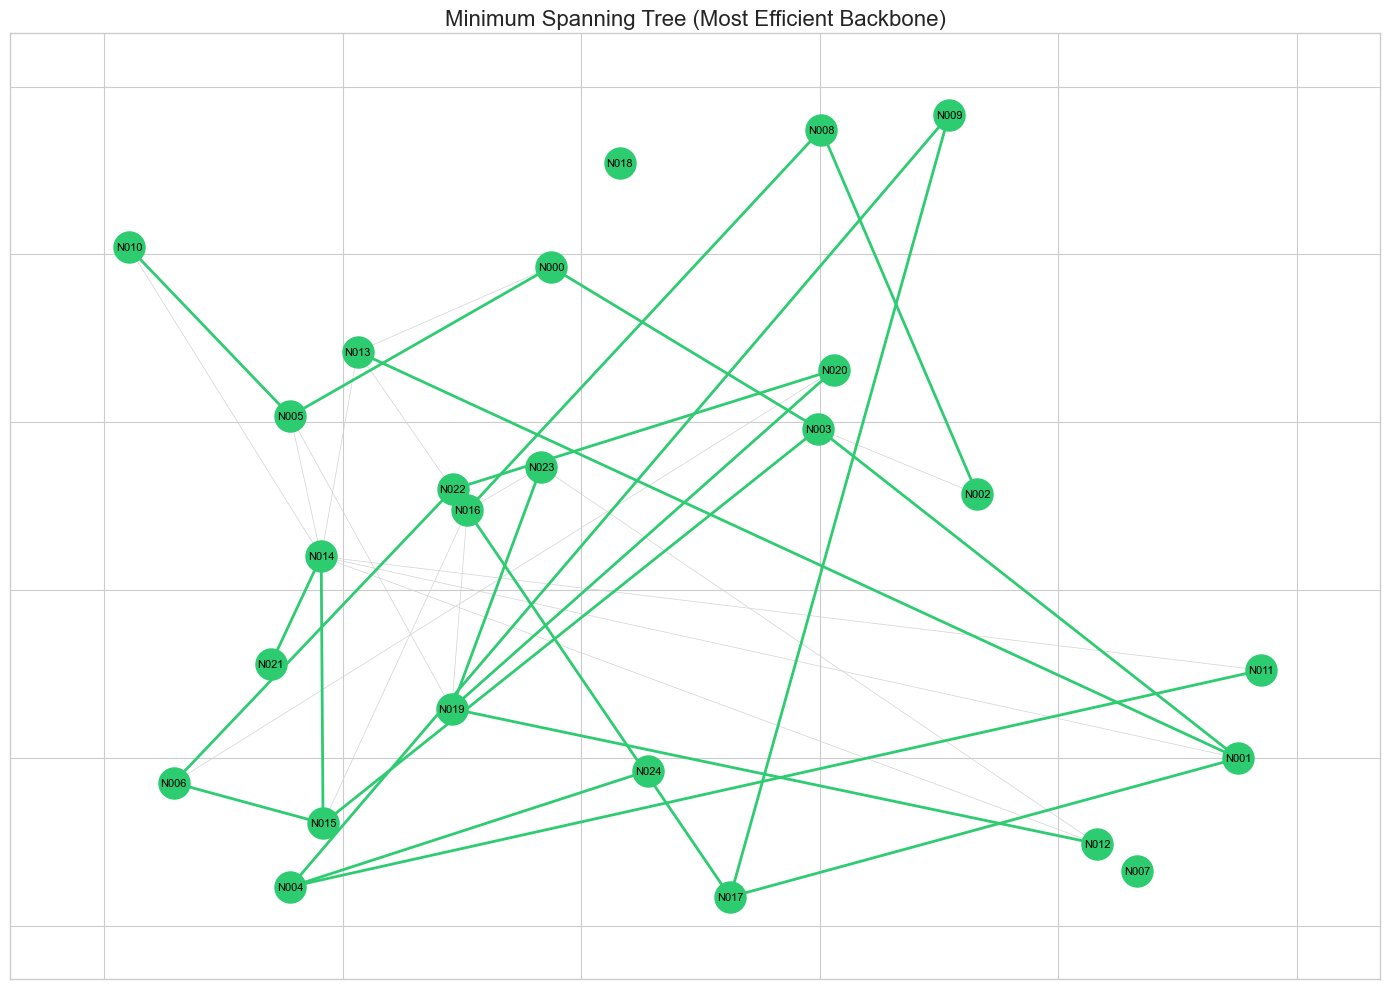

MST visualisation saved to outputs/01g_advanced_algorithms/01g_mst_visualisation.png


In [3]:
# --- Step 2: Minimum Spanning Tree (MST) ---
# 203 # This cell calculates and visualises the Minimum Spanning Tree (MST).
# 203 # The MST is a subset of the edges that connects all nodes together with the
# 203 # minimum possible total edge weight (in our case, minimum total travel time).

def calculate_mst(G: nx.Graph) -> nx.Graph:
    """Calculates the Minimum Spanning Tree of the graph."""
    # 203 # The MST algorithm requires an undirected graph.
    mst = nx.minimum_spanning_tree(G, weight='weight')
    print(f"Minimum Spanning Tree calculated with {mst.number_of_edges()} edges.")
    return mst

def visualize_mst(G: nx.Graph, mst: nx.Graph, file_path: Path):
    """Visualises the MST overlaid on the original graph."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 10))
    pos = nx.get_node_attributes(G, 'pos')

    # 203 # Draw the full graph dimly.
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=300, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, ax=ax)

    # 203 # Highlight the MST edges and nodes.
    nx.draw_networkx_nodes(G, pos, nodelist=mst.nodes(), node_color='#2ecc71', node_size=500, ax=ax)
    nx.draw_networkx_edges(mst, pos, edge_color='#2ecc71', width=2.0, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', ax=ax)

    ax.set_title("Minimum Spanning Tree (Most Efficient Backbone)", fontsize=16)
    plt.tight_layout()
    fig.savefig(file_path, dpi=200)
    plt.show()
    print(f"MST visualisation saved to {file_path}")

# 203 # Calculate and visualize the MST.
mst = calculate_mst(G)
visualize_mst(G, mst, cfg.mst_viz_file)

In [4]:
# --- Step 3: Maximum Flow ---
# 203 # This cell sets up and solves a maximum flow problem. First, we must
# 203 # add 'capacity' to the edges. We then identify a source (a Warehouse)
# 203 # and a sink (a Hospital) and calculate the maximum flow between them.

def add_edge_capacities(G: nx.Graph) -> nx.DiGraph:
    """Adds random capacities to edges and returns a directed graph."""
    # 203 # Max flow requires a directed graph.
    DG = G.to_directed()
    for u, v in DG.edges():
        # 203 # Assign a hypothetical capacity, e.g., number of deliveries per hour.
        DG.edges[u, v]['capacity'] = random.randint(5, 20)
    print("Added 'capacity' attribute to all edges.")
    return DG


def find_source_and_sink(G: nx.Graph) -> tuple[str | None, str | None]:
    """Finds the first available Warehouse as source and Hospital as sink."""
    source, sink = None, None
    kinds = nx.get_node_attributes(G, 'kind')
    for node, kind in kinds.items():
        if kind == 'Warehouse' and source is None:
            source = node
        if kind == 'Hospital' and sink is None:
            sink = node
    return source, sink


def calculate_maximum_flow(G: nx.DiGraph, source: str, sink: str) -> dict | None:
    """Calculates the maximum flow between a source and a sink."""
    if not source or not sink:
        print("Could not find a suitable source (Warehouse) and/or sink (Hospital).")
        return None
        
    flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capacity')
    
    print(f"--- Maximum Flow Analysis ---")
    print(f"Source: {source} ({G.nodes[source]['name']})")
    print(f"Sink:   {sink} ({G.nodes[sink]['name']})")
    print(f"Maximum Flow Value: {flow_value}")
    
    return {
        "source": source, "source_name": G.nodes[source]['name'],
        "sink": sink, "sink_name": G.nodes[sink]['name'],
        "max_flow_value": flow_value,
        "flow_dictionary": {k: dict(v) for k, v in flow_dict.items()} # Make JSON serializable
    }

# 203 # Run the max flow analysis.
DG = add_edge_capacities(G)
source_node, sink_node = find_source_and_sink(DG)
flow_analysis = calculate_maximum_flow(DG, source_node, sink_node)

Added 'capacity' attribute to all edges.
--- Maximum Flow Analysis ---
Source: N005 (Warehouse-005)
Sink:   N013 (Hospital-013)
Maximum Flow Value: 45


In [6]:
...
# --- Step 4: Final Exports ---
# 203 # This cell saves the final outputs: the graph now augmented with edge
# 203 # capacities, and the JSON summary of the maximum flow analysis.

def export_final_artifacts(G: nx.DiGraph, flow_analysis: dict, graph_path: Path, summary_path: Path):
    """Saves the final graph and max flow analysis."""
    # 203 # Create a copy to avoid modifying the graph in memory during export.
    G_export = G.copy()

    # 203 # SOLVED: Convert the 'pos' tuple attribute back to a string before saving to GraphML,
    # 203 # as the format does not support tuple data types.
    for node, data in G_export.nodes(data=True):
        if 'pos' in data and isinstance(data['pos'], tuple):
            data['pos'] = str(data['pos'])

    # 203 # Save the graph with capacity attributes.
    nx.write_graphml(G_export, graph_path)
    print(f"Final graph with capacity data saved to {graph_path}")
    
    # 203 # Save the flow analysis summary.
    if flow_analysis:
        with open(summary_path, 'w') as f:
            json.dump(flow_analysis, f, indent=2)
        print(f"Max flow analysis summary saved to {summary_path}")

# 203 # Run the export function.
export_final_artifacts(DG, flow_analysis, cfg.output_graph_file, cfg.flow_summary_file)



Final graph with capacity data saved to outputs/01g_advanced_algorithms/final_graph.graphml
Max flow analysis summary saved to outputs/01g_advanced_algorithms/01g_max_flow_analysis.json
